# Objective of Notebook

This notebook investigates an LSTM solution for forecasting **Height** up to $12$ steps into the future, given the wrangled ocean waves time series data.

There are three main parts of the Notebook:

**Part-1 : Experiments on Dynamic Models**
1. Construct a Univariate LSTM model
2. Construct a Multivariate LSTM model
3. Compare Results of the LSTM models for the following:
  - Forecast Cott and Rott Height
  - time steps into the future = 2, 6, 12
4. Conclusion


**Part-2 : Experiments on Dynamic+Static Models**
1. Get best model from part-1 for univariate and multivariate models
2. Experimant and compare
  1. Use static model to predict Cott Height, then use forecast model on predicted Cott height
  2. Use forecast model on Rott Height, then use static model on results to get precition for Cott Height

**Part-3 : Conclusion and Recommendation**
- Summarise findings and list limitations of each model
- Future identified research work requried

# **PART-1 : EXPERIMENTS WITH DYNAMIC MODELS**

# Setup

Load packages, mount drive and import data.


Note that the data is already wrangled from a previous step in the pipeline and is in a usable form for modling (no missing values, etc).

In [ ]:
# [ SETUP ]

# STANDARD IMPORTS
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

# DEEP LEARNING IMPORTS
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from pylab import rcParams
import itertools
import plotly.express as px


# SEASONALITY CHECK
from statsmodels.tsa.stattools import adfuller
from keras.models import load_model
import pickle

In [ ]:
# [ MOUNT DRIVE ]
from google.colab import drive 

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')

# YOUR CURRENT DIRECTORY (FOR REFERENCE)
os.getcwd()

'/content/drive/My Drive/Colab Notebooks'

In [ ]:
# [ GET DATA ]
WAVES_PATH = ""
WAVES_FNAME = "ocean-waves-full.csv"

def load_wave_data(waves_path=WAVES_PATH): 
    csv_path_data = os.path.join(waves_path, WAVES_FNAME) 
    return pd.read_csv(csv_path_data, parse_dates=['DateTime'], index_col="DateTime")

In [ ]:
# LOAD AND DISPLAY
waves = load_wave_data()

waves['DateTime'] = waves.index   # keep DateTime as a separate col for plotting

waves.tail()

,Month,CottHeight,CottPeakPeriod,CottMeanPeriod,CottDirection,CottRadiansRotated,RottHeight,RottMeanPeriod,RottPeakPeriod,RottDirection,RottRadiansRotated,TimeShiftTotal,CottTimeShift,RottTimeShift,RecordGroup,CottDateTimeOrig,RottDateTimeOrig,DateTime
DateTime,,,,,,,,,,,,,,,,,,
2019-07-20 00:30:00,7,2.07,13.333333,5.633803,248.90625,0.504509,3.30,7.272727,14.285714,240.46875,0.357247,10,10,0,25,2019-07-20 00:20:00,2019-07-20 00:30:00,2019-07-20 00:30:00
2019-07-20 01:00:00,7,2.11,10.000000,5.714286,275.62500,0.970839,3.57,7.843137,15.384615,233.43750,0.234529,10,10,0,25,2019-07-20 00:50:00,2019-07-20 01:00:00,2019-07-20 01:00:00
2019-07-20 01:30:00,7,1.98,10.000000,5.555556,260.15625,0.700859,3.24,7.407407,14.285714,229.21875,0.160897,10,10,0,25,2019-07-20 01:20:00,2019-07-20 01:30:00,2019-07-20 01:30:00
2019-07-20 02:00:00,7,2.04,14.285714,5.633803,251.71875,0.553597,4.40,10.000000,28.571429,43.59375,-3.078870,10,10,0,25,2019-07-20 01:50:00,2019-07-20 02:00:00,2019-07-20 02:00:00
2019-07-20 02:30:00,7,2.01,11.764706,5.405405,244.68750,0.430878,3.47,8.333333,16.666667,223.59375,0.062723,10,10,0,25,2019-07-20 02:20:00,2019-07-20 02:30:00,2019-07-20 02:30:00


In [ ]:
n = 6
epoch = 100

# REMOVE LAST n OBS. FROM DF. USE THESE TO COMPARE MODEL TO REAL RESULTS
trueset = waves.tail(n)     # n true values to compare with forecast results

# CONSTRUCT DF WITH LAST n OBS. REMOVED. USE df TO FORECAST n VALS
df = waves[:-n+1]           # dataset with 'true values' removed. LSTM will try forecast the next n values. Compare with trueset.

# Univariate Model




## Prepare Data (Univariate Model)

We will concentrate on a **Univariate LSTM Model** that predicts **Rottnest Height** given **Rottnest Height** as the only input. This will suffice as our baseline model (**null model**) in which to improve and compare from.

Below are the steps requried to prepare the data for training.

In [ ]:
# SELECT FEATURES INVOLVED IN TRAINING AND PREDICTIONS
cols = ["RottHeight"]

# ISOLATE TRAINING SET WITH ONLY cols THAT ARE REQUIRED
dataset_train = df[cols]

# CONVERT TO ARRAY
training_set = dataset_train.to_numpy()

# PRINT SUMMARY
print("Training set shape: {}".format(training_set.shape) )
print("Features Selected: {}".format(cols))

We are splitting the data to look at 18 hours history(36 time steps) to predict the next time step. During this first experiment we would be forecasting 3 hours (6 ime steps)

Ref: https://github.com/vb100/multivariate-lstm/blob/master/LSTM_model_stocks.ipynb

In [ ]:
# CONSTRUCT X and y SETS
X = []    # each item is a window of size n_past
y = []    # corresponding y val that each window tries to predict

n_future = n    # number of data points to predict in the future
n_past = 36     # number of past data points to use for predicting the future

# BUILD X AND y
for i in range(n_past, len(training_set) - n_future + 1):
  X.append( training_set[ i - n_past:i, 0:dataset_train.shape[1] ] )
  y.append( training_set[ i + n_future - 1:i + n_future, 0 ] )

X, y = np.array(X), np.array(y)

print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))

## Train LSTM Model

The parameters below are chosen arbitrarily. A future point of research would be to test different hyperparameters of the LSTM model to provide an improved model. However, this is not the scope of what this notebook is trying to acheive.

In [ ]:
# BUILD LSTM MODEL
model_univar = Sequential()                                                                               # initialise LSTM neural network

model_univar.add(LSTM(units=64, return_sequences= True, input_shape=(n_past,dataset_train.shape[1])))     # 1st layer
model_univar.add(LSTM(units=30, return_sequences = False))                                                # 2nd layer
model_univar.add(Dropout(0.55))                                                                           # Dropout layer
model_univar.add(Dense(units=1, activation='linear'))                                                     # Output Layer

model_univar.compile(optimizer = Adam(learning_rate=0.0001), loss= 'mean_squared_error')                  # compile model

# PRINT SUMMARY
model_univar.summary()

In [ ]:
# CALLBACK PARAMS
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1) # early stopping if the val_loss does not decrease with subsequent epochs
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1) # Reduction of learning rate if there is no increase in the val_loss 
mcp = ModelCheckpoint(filepath='waveHeightWeights.h5',monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True) # Checkpoints for the best weights
tb = TensorBoard('logs')

# FIT SEQUENTIAL MODEL
history_univar = model_univar.fit(X, y, epochs=epoch, callbacks=[es,rlr,mcp,tb], shuffle=True, validation_split=0.2, verbose=1)

## Evaluation of Model



In [ ]:
print(history_univar.history.keys())

In [ ]:
loss_univar= pd.DataFrame(history_univar.history,columns=(['loss', 'val_loss', 'lr']))
loss_univar.describe()

In [ ]:
# PLOT LOSS VALUES
pyplot.plot(history_univar.history['loss'])
pyplot.plot(history_univar.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()
##print("mean squared error training: ", history_univar.history['loss'])
#print("mean squared error validation: ", history_univar.history['val_loss'])

Please note that the **validation loss is legitimately lower than the training loss**.




Reason #1: Regularization(dropout) applied during training, but not during validation/testing

Reason #2: Training loss is measured during each epoch while validation loss is measured after each epoch

Reason #3: The validation set may be easier than the training set (or there may be leaks)

https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/



In [ ]:
# PREDICTIONS MADE ON PAST VALUES
predictions_past = model_univar.predict(X[n_past:])

# CONSTRUCT A DF TO HOLD RESULTS
univar_pst_result_df = dataset_train[2 * n_past + n_future -1:].copy()                    # now reference the true set
univar_pst_result_df['PastRottHeight'] = predictions_past                                 # add prediction column to trueset
univar_pst_result_df = univar_pst_result_df.rename(columns={"RottHeight": "ActlRottHeight"})

# FINAL RESULT
univar_pst_result_df.tail()

In [ ]:
# PERFORM PREDICTIONS FOR n VALUES
predictions_future = model_univar.predict(X[-n_future:])

# CONSTRUCT A DF TO HOLD RESULTS
univar_result_df = trueset[cols].copy()                    # now reference the true set
univar_result_df['FrcstRottHeight'] = predictions_future   # add prediction column to trueset
univar_result_df = univar_result_df.rename(columns={"RottHeight": "ActlRottHeight"})

# FINAL RESULT
univar_result_df

In [ ]:
# VISUALISE PREDICTIONS

rcParams['figure.figsize'] = 14,5

# plot Parameters
START_DATE_FOR_PLOTTING = '2019-07-18 00:30:00'
# FORECASTED DATA (RED)
plt.plot(univar_result_df.index, univar_result_df['FrcstRottHeight'], color='r', label= 'Forecasted Wave Height')

# ACTUAL ROTT DATA (BLUE)
plt.plot(univar_result_df.index, univar_result_df['ActlRottHeight'], color='b')

# PREVIOUS ROTT HEIGHT DATA (BLUE)
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING: ].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['RottHeight'], color='b', label = "Actual Wave Height")

# PREDICTED ROTT HEIGHT (ORANGE)
plt.plot(univar_pst_result_df.loc[START_DATE_FOR_PLOTTING: ].index, univar_pst_result_df.loc[START_DATE_FOR_PLOTTING:]['PastRottHeight'], color='orange', label = "Predicted Wave Height")

# VERTICAL LINE (GREEN)
plt.axvline(x=min(univar_result_df.index), color='green', linewidth=2,linestyle='--')

# AESTHETICS
plt.grid(which='major', color='#cccccc', alpha=0.5)
plt.legend(shadow=True)
plt.title("Forecasted Results Univariate Model")

# Multivariate Model

We will concentrate on a **Multivariate LSTM Model** that predicts **Rottnest Height** given **RottHeight**,	**RottMeanPeriod**,	**RottPeakPeriod**,	**RottRadiansRotated** as the inputs. It is expected that increasing the complexity of the model will reduce the variance and produce a better forecast in comparison to the **null model**.

Below are the steps requried to prepare the data for training.

We will keep the keras model structure and hyperparameters identical to the univariate model in order to have a controlled experiment.

## Prepare Data (Multivariate Model)



Below are the steps requried to prepare the data for training.

In [ ]:
# SELECT FEATURES INVOLVED IN TRAINING AND PREDICTIONS
cols = ["RottHeight",	"RottMeanPeriod",	"RottPeakPeriod",	"RottRadiansRotated"]

# ISOLATE TRAINING SET WITH ONLY cols THAT ARE REQUIRED
dataset_train = df[cols]

# CONVERT TO ARRAY
training_set = dataset_train.to_numpy()

# PRINT SUMMARY
print("Training set shape: {}".format(training_set.shape) )
print("Features Selected: {}".format(cols))

In [ ]:
# CONSTRUCT X and y SETS
X_mv = []    # each item is a window of size n_past
y_mv = []    # corresponding y val that each window tries to predict

n_future = n    # number of data points to predict in the future
n_past = 24     # number of past data points to use for predicting the future

# BUILD X AND y
for i in range(n_past, len(training_set) - n_future + 1):
  X_mv.append( training_set[ i - n_past:i, 0:dataset_train.shape[1] ] )
  y_mv.append( training_set[ i + n_future - 1:i + n_future, 0 ] )

X_mv, y_mv = np.array(X_mv), np.array(y_mv)

print("X shape: {}".format(X_mv.shape))
print("y shape: {}".format(y_mv.shape))

## Train LSTM Model

In [ ]:
# BUILD LSTM MODEL
model_multivar = Sequential()                                                                               # initialise LSTM neural network

model_multivar.add(LSTM(units=64, return_sequences= True, input_shape=(n_past,dataset_train.shape[1])))     # 1st layer
model_multivar.add(LSTM(units=64, return_sequences = False))                                                # 2nd layer
model_multivar.add(Dropout(0.55))                                                                           # Dropout layer
model_multivar.add(Dense(units=1, activation='linear'))                                                     # Output Layer

model_multivar.compile(optimizer = Adam(learning_rate=0.0001),loss= 'mean_squared_error')                    # compile model

# PRINT SUMMARY
model_multivar.summary()

In [ ]:
# CALLBACK PARAMS
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='waveHeightWeights.h5',monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')

# FIT SEQUENTIAL MODEL
history_multivar = model_multivar.fit(X_mv, y_mv, epochs=epoch, callbacks=[es,rlr,mcp,tb], shuffle=True, validation_split=0.2, verbose=1)

## Evaluation of Model

todo.

In [ ]:
# PREDICTIONS MADE ON PAST VALUES
predictions_past = model_multivar.predict(X_mv[n_past:])

# CONSTRUCT A DF TO HOLD RESULTS
multivar_pst_result_df = dataset_train[2 * n_past + n_future -1:].copy()                    # now reference the true set
multivar_pst_result_df['PastRottHeight'] = predictions_past                                 # add prediction column to trueset
multivar_pst_result_df = multivar_pst_result_df.rename(columns={"RottHeight": "ActlRottHeight"})

# FINAL RESULT
multivar_pst_result_df.tail()

In [ ]:
# PERFORM PREDICTIONS FOR n VALUES
predictions_future = model_multivar.predict(X_mv[-n_future:])

# CONSTRUCT A DF TO HOLD RESULTS
multivar_result_df = trueset[cols].copy()                    # now reference the true set
multivar_result_df['FrcstRottHeight'] = predictions_future   # add prediction column to trueset
multivar_result_df = multivar_result_df.rename(columns={"RottHeight": "ActlRottHeight"})

# FINAL RESULT
multivar_result_df

In [ ]:
# PLOT LOSS VALUES
pyplot.plot(history_multivar.history['loss'])
pyplot.plot(history_multivar.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()
print("mean squared error training: ", history_multivar.history['loss'])
print("mean squared error validation: ", history_multivar.history['val_loss'])

Please note that the validation loss is **legitimately lower than the training loss.**

Reason #1: Regularization(dropout) applied during training, but not during validation/testing

Reason #2: Training loss is measured during each epoch while validation loss is measured after each epoch

Reason #3: The validation set may be easier than the training set (or there may be leaks)

https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/

In [ ]:
# VISUALISE PREDICTIONS

rcParams['figure.figsize'] = 14,5

# plot Parameters
START_DATE_FOR_PLOTTING = '2018-11-10 22:30:00'

# FORECASTED DATA (RED)
plt.plot(multivar_result_df.index, multivar_result_df['FrcstRottHeight'], color='r', label= 'Forecasted Wave Height')

# ACTUAL ROTT DATA (BLUE)
plt.plot(multivar_result_df.index, multivar_result_df['ActlRottHeight'], color='b')

# PREVIOUS ROTT HEIGHT DATA (BLUE)
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING: ].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['RottHeight'], color='b', label = "Actual Wave Height")

# PREDICTED ROTT HEIGHT (ORANGE)
plt.plot(multivar_pst_result_df.loc[START_DATE_FOR_PLOTTING: ].index, multivar_pst_result_df.loc[START_DATE_FOR_PLOTTING:]['PastRottHeight'], color='orange', label = "Predicted Wave Height")

# VERTICAL LINE (GREEN)
plt.axvline(x=min(multivar_result_df.index), color='green', linewidth=2,linestyle='--')

# AESTHETICS
plt.grid(which='major', color='#cccccc', alpha=0.5)
plt.legend(shadow=True)
plt.title("Forecasted Results Univariate Model")

# Comparison of Results

**DO NOT RUN THIS SECTION UNLESS NO H5 FILES ARE AVAILABLE.(H5 FILES ARE PROVIDED)** 

- ETA FOR UNIVARIATE   : 2 HOURS ON COLAB (WITH GPU)
- ETA FOR MULTIVARIATE : 2 HOURS ON COLAB (WITH GPU)
This section lists down the experiments on both multivariate and univariate  lstm forecasting models developed above

Both the comparisons below are cycling through following: 
  - Forecast on Cottesloe inputs and Rottnest inputs
  - Time steps into the future = 2, 6, 12

## UniVariate Comparison

In [ ]:
"""
TRAINS ALL MODELS
"""


# LOAD AND DISPLAY
waves = load_wave_data()
waves['DateTime'] = waves.index   # keep DateTime as a separate col for plotting
epoch = 1

# SELECT FEATURES INVOLVED IN TRAINING AND PREDICTIONS
# MAKE INTO FOR LOOP
# cols = [ ["RottHeight"], ["CottHeight"], ["RottHeight",	"RottMeanPeriod",	"RottPeakPeriod",	"RottRadiansRotated"], ["CottHeight",	"CottMeanPeriod",	"CottPeakPeriod",	"CottRadiansRotated"] ]
cols = [["RottHeight"],['CottHeight']]   # --------- Situations: ["RottHeight"], ["CottHeight"], ["RottHeight",	"RottMeanPeriod",	"RottPeakPeriod",	"RottRadiansRotated"], ["CottHeight",	"CottMeanPeriod",	"CottPeakPeriod",	"CottRadiansRotated"]
columnss = ['RottHeight', 'CottHeight']
Final_df = pd.DataFrame(waves, columns=columnss,index=waves.index)
loss_hist=[]
loss_hist_ar = np.array(loss_hist, dtype = np.float32)

val_loss_hist=[]
loss_val_hist_ar = np.array(val_loss_hist, dtype = np.float32)

all_models = []


#Loop
for colus,coluss in zip(cols,columnss):
  
  n_vals = [2, 6, 12]
  n_past = 96 
  # CONSTRUCT TRAINING SET ----------
  
  # MODEL
  #model = model_univar

  # final_df_res =  TODO


  for n in n_vals:

    # PREPARE DATASET -----------
    # REMOVE LAST n OBS. FROM DF. USE THESE TO COMPARE MODEL TO REAL RESULTS
    trueset = waves.tail(n)     # n true values to compare with forecast results
    # CONSTRUCT DF WITH LAST n OBS. REMOVED. USE df TO FORECAST n VALS
    df = waves[:-n+1]           # dataset with 'true values' removed. LSTM will try forecast the next n values. Compare with trueset.
    # ISOLATE TRAINING SET WITH ONLY cols THAT ARE REQUIRED
    dataset_train = df[colus]
    # CONVERT TO ARRAY
    training_set = dataset_train.to_numpy()
    # CONSTRUCT X and y SETS ----
    X = []    # each item is a window of size n_past
    y = []    # corresponding y val that each window tries to predict

    n_future = n    # number of data points to predict in the future
      # number of past data points to use for predicting the future

    # BUILD X AND y
    for i in range(n_past, len(training_set) - n_future + 1):
      X.append( training_set[ i - n_past:i, 0:dataset_train.shape[1] ] )
      y.append( training_set[ i + n_future - 1:i + n_future, 0 ] )

    X, y = np.array(X), np.array(y)

    # BUILD LSTM MODEL
    model_univar = Sequential()                                                                               # initialise LSTM neural network

    model_univar.add(LSTM(units=64, return_sequences= True, input_shape=(n_past,dataset_train.shape[1])))     # 1st layer
    model_univar.add(LSTM(units=30, return_sequences = False))                                                # 2nd layer
    model_univar.add(Dropout(0.55))                                                                           # Dropout layer
    model_univar.add(Dense(units=1, activation='linear'))                                                     # Output Layer

    model_univar.compile(optimizer = Adam(learning_rate=0.0001), loss= 'mean_squared_error')                  # compile model
    model = model_univar
    # PRINT SUMMARY
    #model_univar.summary()
    # NOW TRAIN MODEL ------
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
    mcp = ModelCheckpoint(filepath='{}_Uni_{:02d} Step_HeightWeights.h5'.format(coluss,n),monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    tb = TensorBoard('logs')

    _hist_model = model.fit(X, y, epochs=epoch, callbacks=[es,rlr,mcp,tb], shuffle=True, validation_split=0.2, verbose=1)

    # ADD MODEL TO FINAL ARRAY
    all_models.append(_hist_model)

    # MAKE PREDICTIONS ------
    # PREDICTIONS MADE ON PAST VALUES
    predictions_past = model.predict(X[n_past:])


    # PREDICTIONS MADE ON PAST VALUES
    #predictions_past = model_multivar.predict(X_mv[n_past:])

    # PREDICTIONS MADE ON PAST VALUES
    #predictions_past = model_univar.predict(X[n_past:])

    # CONSTRUCT A DF TO HOLD RESULTS
    univar_pst_result_df = dataset_train[2 * n_past + n_future -1:].copy()                    # now reference the true set
    univar_pst_result_df["{} on {} Forecast ".format(colus,n)] = predictions_past
    univar_pst_result_df=univar_pst_result_df.drop(univar_pst_result_df.columns.difference(["{} on {} Forecast ".format(colus,n)]), axis=1)                               # add prediction column to trueset
    #univar_pst_result_df = univar_pst_result_df.rename(columns={"{} on {} Forecast ".format(cols,n): "ActlRottHeight"})
    # FINAL RESULT
    
    Final_df=Final_df.join(univar_pst_result_df)
    

    # ADD TO FINAL DF
    # hist.history['val_loss'][-1]
    loss_hist_ar = np.append(loss_hist_ar,_hist_model.history['loss'][-1])
    loss_val_hist_ar = np.append(loss_val_hist_ar,_hist_model.history['val_loss'][-1]) 

In [ ]:
Final_df.head(300)

,RottHeight,CottHeight,['RottHeight'] on 2 Forecast,['RottHeight'] on 6 Forecast,['RottHeight'] on 12 Forecast,['CottHeight'] on 2 Forecast,['CottHeight'] on 6 Forecast,['CottHeight'] on 12 Forecast
DateTime,,,,,,,,
2015-12-17 22:30:00,2.17,0.69,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-17 23:00:00,1.96,0.70,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-17 23:30:00,2.27,0.72,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-18 00:00:00,2.09,0.74,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-18 00:30:00,2.11,0.74,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2015-12-24 02:00:00,2.70,1.18,2.593961,2.736090,2.583727,1.168156,1.136772,1.257436
2015-12-24 02:30:00,2.54,1.14,2.441088,2.720769,2.642169,1.133106,1.229785,1.320964
2015-12-24 03:00:00,2.73,1.19,2.522441,2.638767,2.697584,1.126815,1.274045,1.366556


In [ ]:
Final_df.columns

Index(['RottHeight', 'CottHeight', '['RottHeight'] on 2 Forecast ',
       '['RottHeight'] on 6 Forecast ', '['RottHeight'] on 12 Forecast ',
       '['CottHeight'] on 2 Forecast ', '['CottHeight'] on 6 Forecast ',
       '['CottHeight'] on 12 Forecast '],
      dtype='object')

###Univariate MSE

Univariate MSEs
Rott Height 2 Steps Forecast : 0.025
Rott Height 6 Steps Forecast: 0.058
Rott Height 12 Steps Forecast: 0.13
Cott Height 2 Steps Forecast: 0.007
Cott Height 6 Steps Forecast: 0.017
Cott Height 12 Steps Forecast: 0.038


**NOTE:**

Please note that the validation loss is legitimately lower than the training loss.

Reason #1: Regularization(dropout) applied during training, but not during validation/testing

Reason #2: Training loss is measured during each epoch while validation loss is measured after each epoch

Reason #3: The validation set may be easier than the training set (or there may be leaks)

https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/

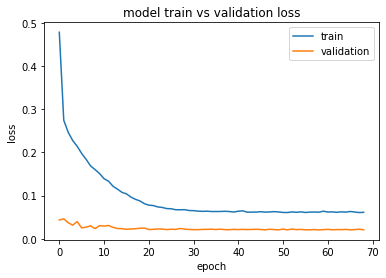

mean squared error training:  [0.47817283868789673, 0.27425330877304077, 0.24630863964557648, 0.22729526460170746, 0.213919997215271, 0.19754856824874878, 0.18377503752708435, 0.16849330067634583, 0.1600589156150818, 0.15085795521736145, 0.13902828097343445, 0.13324366509914398, 0.1215728148818016, 0.11482259631156921, 0.10747409611940384, 0.10382099449634552, 0.09654892981052399, 0.09130585193634033, 0.08764553815126419, 0.0811711996793747, 0.0777832418680191, 0.07680800557136536, 0.07369589805603027, 0.07239626348018646, 0.06984902173280716, 0.06940669566392899, 0.06714773178100586, 0.06707355380058289, 0.06728312373161316, 0.06531516462564468, 0.0650579184293747, 0.06390290707349777, 0.0633806586265564, 0.06380163133144379, 0.06298947334289551, 0.06304152309894562, 0.06313250213861465, 0.06353335082530975, 0.062980055809021, 0.06186225637793541, 0.06373190879821777, 0.06456426531076431, 0.06146617233753204, 0.06165686622262001, 0.06168554350733757, 0.0625704750418663, 0.061595715582

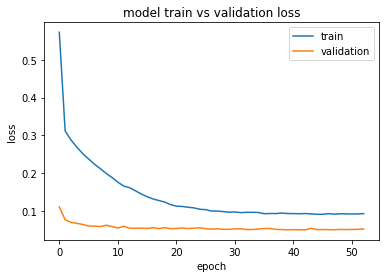

mean squared error training:  [0.5725471377372742, 0.311803936958313, 0.2880394160747528, 0.268945574760437, 0.2521928548812866, 0.23796863853931427, 0.22409115731716156, 0.2124992311000824, 0.199830561876297, 0.18906529247760773, 0.176600843667984, 0.166331946849823, 0.16210812330245972, 0.15398311614990234, 0.1453748196363449, 0.13829466700553894, 0.13235609233379364, 0.1281764656305313, 0.12417364120483398, 0.11737120896577835, 0.11327157914638519, 0.1124446839094162, 0.11037176847457886, 0.1087857261300087, 0.10506047308444977, 0.10405796021223068, 0.1002822071313858, 0.10036540776491165, 0.09885065257549286, 0.09740433096885681, 0.09798841178417206, 0.09623032808303833, 0.09689652174711227, 0.09700193256139755, 0.09652864187955856, 0.09331033378839493, 0.09389574825763702, 0.093728207051754, 0.09501459449529648, 0.09376924484968185, 0.09363093972206116, 0.09317386150360107, 0.09374647587537766, 0.09285064041614532, 0.09172549843788147, 0.09176856279373169, 0.09350728243589401, 0.0

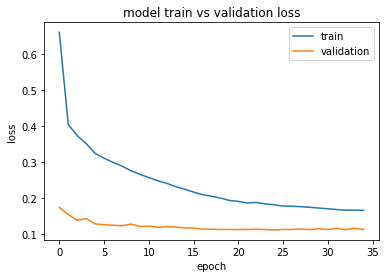

mean squared error training:  [0.6603929996490479, 0.4039064347743988, 0.37284860014915466, 0.35071855783462524, 0.323784202337265, 0.3100409507751465, 0.2986464202404022, 0.28817224502563477, 0.27530646324157715, 0.2651974856853485, 0.25610679388046265, 0.24752309918403625, 0.24014177918434143, 0.23110023140907288, 0.22395560145378113, 0.21597127616405487, 0.20874132215976715, 0.2044592946767807, 0.19931256771087646, 0.19267098605632782, 0.19001168012619019, 0.1857985556125641, 0.18706631660461426, 0.18295979499816895, 0.18069934844970703, 0.17695671319961548, 0.17667104303836823, 0.17527513206005096, 0.17358353734016418, 0.17144854366779327, 0.16953310370445251, 0.16725526750087738, 0.165823832154274, 0.16577960550785065, 0.16511254012584686]
mean squared error validation:  [0.1731628030538559, 0.15371857583522797, 0.13745327293872833, 0.142231747508049, 0.12742029130458832, 0.12504340708255768, 0.12367605417966843, 0.12214983999729156, 0.12691108882427216, 0.12034779787063599, 0.121

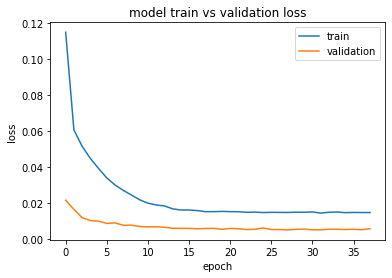

mean squared error training:  [0.11493252962827682, 0.060665059834718704, 0.05152856931090355, 0.04478788748383522, 0.03916608914732933, 0.0339411236345768, 0.030022310093045235, 0.027018969878554344, 0.024427523836493492, 0.021743234246969223, 0.019904140383005142, 0.01888876222074032, 0.018365085124969482, 0.01674605719745159, 0.016093330457806587, 0.016102200374007225, 0.015778789296746254, 0.015149428509175777, 0.01519010215997696, 0.015317368321120739, 0.015193639323115349, 0.015135485678911209, 0.014813536778092384, 0.014912824146449566, 0.014684402383863926, 0.014794041402637959, 0.01476746704429388, 0.014715179800987244, 0.01488562859594822, 0.014840933494269848, 0.015015514567494392, 0.01436490099877119, 0.01483163982629776, 0.014959579333662987, 0.01463230513036251, 0.014733510091900826, 0.014682908542454243, 0.014673094265162945]
mean squared error validation:  [0.021545952185988426, 0.016414470970630646, 0.011868001893162727, 0.010169820860028267, 0.009891115128993988, 0.00

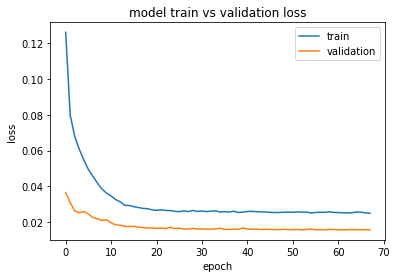

mean squared error training:  [0.12600035965442657, 0.07982511818408966, 0.06779561191797256, 0.06066862493753433, 0.054739225655794144, 0.04946347698569298, 0.045585040003061295, 0.04181869700551033, 0.038450948894023895, 0.036211177706718445, 0.03458679839968681, 0.03265320509672165, 0.03137028589844704, 0.02941596321761608, 0.02932528778910637, 0.028663378208875656, 0.028188925236463547, 0.027728678658604622, 0.02753157541155815, 0.026935869827866554, 0.026628045365214348, 0.026901520788669586, 0.02657577581703663, 0.02650667168200016, 0.026115156710147858, 0.02584018185734749, 0.026338722556829453, 0.02594274841248989, 0.026558732613921165, 0.02600189670920372, 0.026224607601761818, 0.025966119021177292, 0.026172257959842682, 0.02633892558515072, 0.02564369887113571, 0.025934359058737755, 0.025651920586824417, 0.02614639513194561, 0.02544109895825386, 0.025602763518691063, 0.025981640443205833, 0.026062170043587685, 0.025879284366965294, 0.02576698176562786, 0.02572661265730858, 0.

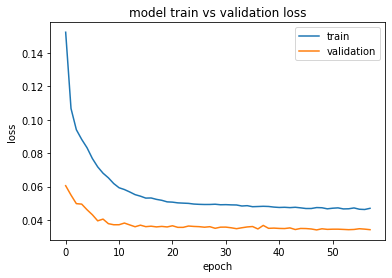

mean squared error training:  [0.15246450901031494, 0.10677577555179596, 0.09406323730945587, 0.08825526386499405, 0.08324872702360153, 0.07680317759513855, 0.0717778429389, 0.06799264997243881, 0.0652255117893219, 0.061786919832229614, 0.059275589883327484, 0.05820199474692345, 0.05674728751182556, 0.055151160806417465, 0.05422844737768173, 0.05307196080684662, 0.05315016210079193, 0.05231454223394394, 0.05174906551837921, 0.05082045495510101, 0.050652071833610535, 0.05021917074918747, 0.05005766823887825, 0.04991278052330017, 0.04950368404388428, 0.049333855509757996, 0.0492442324757576, 0.049254272133111954, 0.04939940571784973, 0.049083150923252106, 0.04914788156747818, 0.04901285097002983, 0.04894736409187317, 0.04833658039569855, 0.04853416606783867, 0.047919727861881256, 0.04803192988038063, 0.04816059395670891, 0.048057448118925095, 0.04768277332186699, 0.04746335744857788, 0.04756776615977287, 0.04736754298210144, 0.047575172036886215, 0.04723155125975609, 0.04683065414428711,

In [ ]:
# DISPLAY ALL HISTORY LOSS CURVES FOR EACH MODEL ABOVE (NOTE: REPEATE FOR EACH x4)

for hist in all_models:
  # PLOT LOSS VALUES
  pyplot.plot(hist.history['loss'])
  pyplot.plot(hist.history['val_loss'])
  pyplot.title('model train vs validation loss')
  pyplot.ylabel('loss')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'validation'], loc='upper right')
  pyplot.show()
  print("mean squared error training: ", hist.history['loss'])
  print("mean squared error validation: ", hist.history['val_loss'])

## Multivariate Comparison

In [ ]:
"""
TRAINS ALL MODELS
"""


# LOAD AND DISPLAY
waves = load_wave_data()
waves['DateTime'] = waves.index   # keep DateTime as a separate col for plotting
epoch = 100

# SELECT FEATURES INVOLVED IN TRAINING AND PREDICTIONS
# MAKE INTO FOR LOOP
# cols = [ ["RottHeight"], ["CottHeight"], ["RottHeight",	"RottMeanPeriod",	"RottPeakPeriod",	"RottRadiansRotated"], ["CottHeight",	"CottMeanPeriod",	"CottPeakPeriod",	"CottRadiansRotated"] ]
cols = [["RottHeight",	"RottMeanPeriod",	"RottPeakPeriod",	"RottRadiansRotated"],["CottHeight",	"CottMeanPeriod",	"CottPeakPeriod",	"CottRadiansRotated"]]   # --------- Situations: ["RottHeight"], ["CottHeight"], ["RottHeight",	"RottMeanPeriod",	"RottPeakPeriod",	"RottRadiansRotated"], ["CottHeight",	"CottMeanPeriod",	"CottPeakPeriod",	"CottRadiansRotated"]
column_multi = ['RottHeight', 'CottHeight']
multi_Final_df = pd.DataFrame(waves, columns=column_multi,index=waves.index)
multi_loss_hist=[]
multi_loss_hist_ar = np.array(multi_loss_hist, dtype = np.float32)

multi_val_loss_hist=[]
multi_loss_val_hist_ar = np.array(multi_val_loss_hist, dtype = np.float32)

multi_all_models = []


#Loop
for colus in cols:
  
  n_vals = [2, 6, 12]
  n_past = 96 
  # CONSTRUCT TRAINING SET ----------
  
  # MODEL
  #model = model_univar

  # final_df_res =  TODO


  for n in n_vals:

    # PREPARE DATASET -----------
    # REMOVE LAST n OBS. FROM DF. USE THESE TO COMPARE MODEL TO REAL RESULTS
    trueset = waves.tail(n)     # n true values to compare with forecast results
    # CONSTRUCT DF WITH LAST n OBS. REMOVED. USE df TO FORECAST n VALS
    df = waves[:-n+1]           # dataset with 'true values' removed. LSTM will try forecast the next n values. Compare with trueset.
    # ISOLATE TRAINING SET WITH ONLY cols THAT ARE REQUIRED
    dataset_train = df[colus]
    # CONVERT TO ARRAY
    training_set = dataset_train.to_numpy()
    # CONSTRUCT X and y SETS ----
    X = []    # each item is a window of size n_past
    y = []    # corresponding y val that each window tries to predict

    n_future = n    # number of data points to predict in the future
      # number of past data points to use for predicting the future

    # BUILD X AND y
    for i in range(n_past, len(training_set) - n_future + 1):
      X.append( training_set[ i - n_past:i, 0:dataset_train.shape[1] ] )
      y.append( training_set[ i + n_future - 1:i + n_future, 0 ] )

    X, y = np.array(X), np.array(y)

    # BUILD LSTM MODEL
    model_multivar = Sequential()                                                                               # initialise LSTM neural network

    model_multivar.add(LSTM(units=64, return_sequences= True, input_shape=(n_past,dataset_train.shape[1])))     # 1st layer
    model_multivar.add(LSTM(units=30, return_sequences = False))                                                # 2nd layer
    model_multivar.add(Dropout(0.55))                                                                           # Dropout layer
    model_multivar.add(Dense(units=1, activation='linear'))                                                     # Output Layer

    model_multivar.compile(optimizer = Adam(learning_rate=0.0001), loss= 'mean_squared_error')                  # compile model
    model = model_multivar
    # PRINT SUMMARY
    #model_univar.summary()
    # NOW TRAIN MODEL ------
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=5, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
    mcp = ModelCheckpoint(filepath='{}_Multi_{} Step_HeightWeights.h5'.format(colus[0],n),monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    tb = TensorBoard('logs')

    _hist_model_multi = model.fit(X, y, epochs=epoch, callbacks=[es,rlr,mcp,tb], shuffle=True, validation_split=0.2, verbose=1)

    # ADD MODEL TO FINAL ARRAY
    multi_all_models.append(_hist_model_multi)

    # MAKE PREDICTIONS ------
    # PREDICTIONS MADE ON PAST VALUES
    predictions_past = model.predict(X[n_past:])


    # PREDICTIONS MADE ON PAST VALUES
    #predictions_past = model_multivar.predict(X_mv[n_past:])

    # PREDICTIONS MADE ON PAST VALUES
    #predictions_past = model_univar.predict(X[n_past:])

    # CONSTRUCT A DF TO HOLD RESULTS
    multi_pst_result_df = dataset_train[2 * n_past + n_future -1:].copy()                    # now reference the true set
    multi_pst_result_df["{} on {} Step Forecast ".format(colus[0],n)] = predictions_past
    multi_pst_result_df=multi_pst_result_df.drop(multi_pst_result_df.columns.difference(["{} on {} Step Forecast ".format(colus[0],n)]), axis=1)                               # add prediction column to trueset
    #univar_pst_result_df = univar_pst_result_df.rename(columns={"{} on {} Forecast ".format(cols,n): "ActlRottHeight"})
    # FINAL RESULT
    
    multi_Final_df=multi_Final_df.join(multi_pst_result_df)
    

    # ADD TO FINAL DF
    # hist.history['val_loss'][-1]
    multi_loss_hist_ar = np.append(multi_loss_hist_ar,_hist_model_multi.history['loss'][-1])
    multi_loss_val_hist_ar = np.append(multi_loss_val_hist_ar,_hist_model_multi.history['val_loss'][-1]) 

Epoch 1/100
1504/1504 [==============================] - ETA: 0s - loss: 0.6133
Epoch 00001: val_loss improved from inf to 0.06506, saving model to RottHeight_2 Step_MultiwaveHeightWeights.h5
1504/1504 [==============================] - 23s 15ms/step - loss: 0.6133 - val_loss: 0.0651
Epoch 2/100
1501/1504 [============================>.] - ETA: 0s - loss: 0.2898
Epoch 00002: val_loss improved from 0.06506 to 0.04221, saving model to RottHeight_2 Step_MultiwaveHeightWeights.h5
1504/1504 [==============================] - 22s 15ms/step - loss: 0.2896 - val_loss: 0.0422
Epoch 3/100
1502/1504 [============================>.] - ETA: 0s - loss: 0.2652
Epoch 00003: val_loss improved from 0.04221 to 0.03546, saving model to RottHeight_2 Step_MultiwaveHeightWeights.h5
1504/1504 [==============================] - 22s 15ms/step - loss: 0.2650 - val_loss: 0.0355
Epoch 4/100
1503/1504 [============================>.] - ETA: 0s - loss: 0.2418
Epoch 00004: val_loss did not improve from 0.03546
1504/1

In [ ]:
**NOTE:**

Please note that the validation loss is legitimately lower than the training loss.

Reason #1: Regularization(dropout) applied during training, but not during validation/testing

Reason #2: Training loss is measured during each epoch while validation loss is measured after each epoch

Reason #3: The validation set may be easier than the training set (or there may be leaks)

https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/

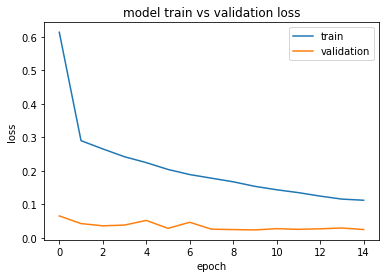

mean squared error training:  [0.6132825016975403, 0.2896161377429962, 0.2650337815284729, 0.24173042178153992, 0.22413423657417297, 0.20373249053955078, 0.18847177922725677, 0.1776900291442871, 0.16691632568836212, 0.15328481793403625, 0.14308148622512817, 0.13454388082027435, 0.12418627738952637, 0.11520039290189743, 0.11185004562139511]
mean squared error validation:  [0.06505846232175827, 0.04220949485898018, 0.03546055778861046, 0.037754230201244354, 0.05160246789455414, 0.02801746502518654, 0.04606013372540474, 0.0255237128585577, 0.024279139935970306, 0.023273374885320663, 0.027001721784472466, 0.02501080185174942, 0.026651743799448013, 0.028935542330145836, 0.02444722130894661]


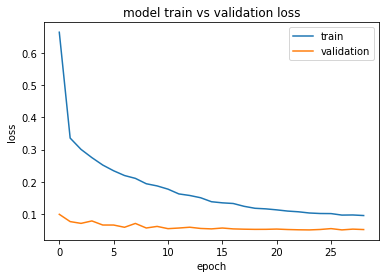

mean squared error training:  [0.6649958491325378, 0.3359607756137848, 0.30075618624687195, 0.27514517307281494, 0.2520633637905121, 0.2342764288187027, 0.21952103078365326, 0.2106766253709793, 0.1939973384141922, 0.18720774352550507, 0.1771756261587143, 0.16232456266880035, 0.1574937403202057, 0.15047067403793335, 0.1380763202905655, 0.13461129367351532, 0.1325712651014328, 0.12378530204296112, 0.11770205944776535, 0.11589474231004715, 0.11277027428150177, 0.10902287065982819, 0.10678090900182724, 0.10304245352745056, 0.10145560652017593, 0.10117550939321518, 0.09649767726659775, 0.09690262377262115, 0.09513489902019501]
mean squared error validation:  [0.09890760481357574, 0.07629896700382233, 0.07075141370296478, 0.0783611387014389, 0.06564615666866302, 0.06558648496866226, 0.05862535908818245, 0.07056986540555954, 0.05639128386974335, 0.06134706735610962, 0.054327331483364105, 0.056294746696949005, 0.05878765508532524, 0.054971691220998764, 0.053640205413103104, 0.05630404502153396

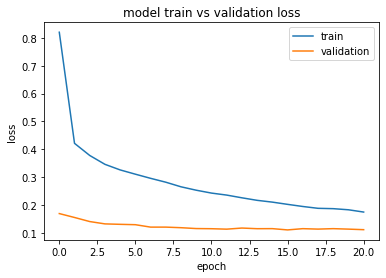

mean squared error training:  [0.8200584650039673, 0.4216483533382416, 0.378135621547699, 0.3463480472564697, 0.3262993395328522, 0.3109826147556305, 0.2961440682411194, 0.2822357714176178, 0.2657160460948944, 0.25352948904037476, 0.24322959780693054, 0.23606671392917633, 0.22630222141742706, 0.21724116802215576, 0.21082502603530884, 0.20281049609184265, 0.19518010318279266, 0.18861784040927887, 0.18736043572425842, 0.18335935473442078, 0.17518837749958038]
mean squared error validation:  [0.16974817216396332, 0.15575018525123596, 0.14113542437553406, 0.13275279104709625, 0.13118144869804382, 0.12986798584461212, 0.12116608023643494, 0.12118509411811829, 0.11909016966819763, 0.11599578708410263, 0.11545544117689133, 0.11386343091726303, 0.11782877147197723, 0.11551865190267563, 0.11572930216789246, 0.1111462190747261, 0.11564736813306808, 0.11404621601104736, 0.1156785637140274, 0.1139894351363182, 0.11201118677854538]


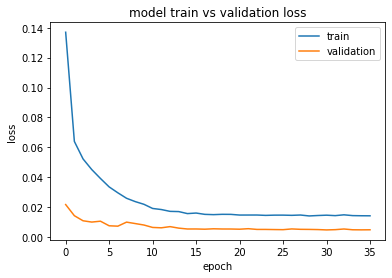

mean squared error training:  [0.13695207238197327, 0.06394832581281662, 0.052239034324884415, 0.04513879865407944, 0.039184413850307465, 0.03354130685329437, 0.029598629102110863, 0.025938620790839195, 0.023715291172266006, 0.021912936121225357, 0.01912756823003292, 0.01840723305940628, 0.017191637307405472, 0.01704161986708641, 0.015697330236434937, 0.01606430672109127, 0.015189491212368011, 0.014998596161603928, 0.0152129540219903, 0.01517654862254858, 0.014720949344336987, 0.014732790179550648, 0.014738362282514572, 0.014505310915410519, 0.014659223146736622, 0.014669429510831833, 0.014531615190207958, 0.014739623293280602, 0.01412847451865673, 0.014418295584619045, 0.014632749371230602, 0.014334450475871563, 0.01487407274544239, 0.014349348843097687, 0.014257312752306461, 0.014220244251191616]
mean squared error validation:  [0.021735278889536858, 0.014287032186985016, 0.01089148037135601, 0.01002830732613802, 0.010616534389555454, 0.007544157560914755, 0.007293954957276583, 0.009

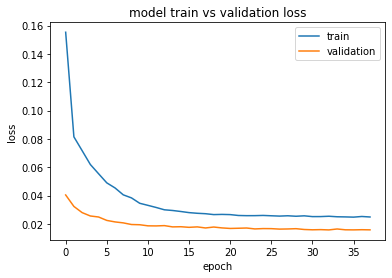

mean squared error training:  [0.1553293615579605, 0.08144809305667877, 0.07169845700263977, 0.061906829476356506, 0.05538326874375343, 0.048931922763586044, 0.04535159096121788, 0.040475767105817795, 0.038317784667015076, 0.03451736271381378, 0.033048972487449646, 0.03154973313212395, 0.029911870136857033, 0.029419662430882454, 0.028706509619951248, 0.02791629172861576, 0.027449140325188637, 0.02714592032134533, 0.02652030438184738, 0.026652226224541664, 0.026511743664741516, 0.025891514495015144, 0.0257622878998518, 0.025777611881494522, 0.025923781096935272, 0.025686247274279594, 0.02545982599258423, 0.02568778768181801, 0.02534947730600834, 0.025647254660725594, 0.02510075457394123, 0.025118183344602585, 0.025351502001285553, 0.024987410753965378, 0.024884957820177078, 0.02472629025578499, 0.025184763595461845, 0.024832749739289284]
mean squared error validation:  [0.04038669168949127, 0.032283250242471695, 0.027923185378313065, 0.025538481771945953, 0.02482595108449459, 0.02240892

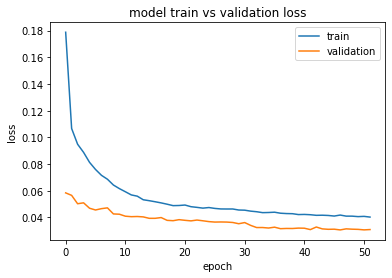

mean squared error training:  [0.17880156636238098, 0.1066310703754425, 0.0948653295636177, 0.08875653892755508, 0.08128540217876434, 0.07595277577638626, 0.07154329121112823, 0.06862057745456696, 0.0642751082777977, 0.06158849596977234, 0.05924718454480171, 0.056858766824007034, 0.05592464655637741, 0.05323202162981033, 0.05253515765070915, 0.05173509940505028, 0.05087792128324509, 0.04989934712648392, 0.04882827401161194, 0.048936061561107635, 0.04927360266447067, 0.048030927777290344, 0.0475284568965435, 0.046958938241004944, 0.04740191623568535, 0.04674387350678444, 0.04634349048137665, 0.0463007390499115, 0.04631544277071953, 0.04554280638694763, 0.04542142525315285, 0.04470048472285271, 0.044262781739234924, 0.04357735440135002, 0.0436808243393898, 0.04390239715576172, 0.04314730316400528, 0.04288984090089798, 0.0427832305431366, 0.04213275760412216, 0.042236145585775375, 0.04201647266745567, 0.04156468063592911, 0.041643984615802765, 0.041463661938905716, 0.0410156324505806, 0.0

In [ ]:
# DISPLAY ALL HISTORY LOSS CURVES FOR EACH MODEL ABOVE (NOTE: REPEATE FOR EACH x4)

for hist in multi_all_models:
  # PLOT LOSS VALUES
  pyplot.plot(hist.history['loss'])
  pyplot.plot(hist.history['val_loss'])
  pyplot.title('model train vs validation loss')
  pyplot.ylabel('loss')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'validation'], loc='upper right')
  pyplot.show()
  print("mean squared error training: ", hist.history['loss'])
  print("mean squared error validation: ", hist.history['val_loss'])

## All MSE

In [ ]:
multi_Final_df.columns

Index(['RottHeight', 'CottHeight', 'RottHeight on 2 Step Forecast ',
       'RottHeight on 6 Step Forecast ', 'RottHeight on 12 Step Forecast ',
       'CottHeight on 2 Step Forecast ', 'CottHeight on 6 Step Forecast ',
       'CottHeight on 12 Step Forecast '],
      dtype='object')

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score


print('Univariate MSEs')

withoutNAN=Final_df.dropna()

Rott_2_forecast=mean_squared_error(withoutNAN['RottHeight'],withoutNAN["['RottHeight'] on 2 Forecast "])
Rott_6_forecast=mean_squared_error(withoutNAN['RottHeight'],withoutNAN["['RottHeight'] on 6 Forecast "])
Rott_12_forecast=mean_squared_error(withoutNAN['RottHeight'],withoutNAN["['RottHeight'] on 12 Forecast "])
# withoutNAN

print('Rott Height 2 Steps Forecast : {:2.2}'.format(Rott_2_forecast))
print('Rott Height 6 Steps Forecast: {:2.2}'.format(Rott_6_forecast))
print('Rott Height 12 Steps Forecast: {:2.2}'.format(Rott_12_forecast))

Cott_2_forecast=mean_squared_error(withoutNAN['CottHeight'],withoutNAN["['CottHeight'] on 2 Forecast "])
Cott_6_forecast=mean_squared_error(withoutNAN['CottHeight'],withoutNAN["['CottHeight'] on 6 Forecast "])
Cott_12_forecast=mean_squared_error(withoutNAN['CottHeight'],withoutNAN["['CottHeight'] on 12 Forecast "])
# withoutNAN


print('Cott Height 2 Steps Forecast: {:2.2}'.format(Cott_2_forecast))
print('Cott Height 6 Steps Forecast: {:2.2}'.format(Cott_6_forecast))
print('Cott Height 12 Steps Forecast: {:2.2}'.format(Cott_12_forecast))


print('Multivariate MSEs')

withoutNAN_multi=multi_Final_df.dropna()
Rott_2_forecast=mean_squared_error(withoutNAN_multi['RottHeight'],withoutNAN_multi["RottHeight on 2 Step Forecast "])
Rott_6_forecast=mean_squared_error(withoutNAN_multi['RottHeight'],withoutNAN_multi["RottHeight on 6 Step Forecast "])
Rott_12_forecast=mean_squared_error(withoutNAN_multi['RottHeight'],withoutNAN_multi["RottHeight on 12 Step Forecast "])
# withoutNAN_multi

print('Rott Height 2 Steps Forecast : {:2.2}'.format(Rott_2_forecast))
print('Rott Height 6 Steps Forecast: {:2.2}'.format(Rott_6_forecast))
print('Rott Height 12 Steps Forecast: {:2.2}'.format(Rott_12_forecast))

Cott_2_forecast=mean_squared_error(withoutNAN_multi['CottHeight'],withoutNAN_multi["CottHeight on 2 Step Forecast "])
Cott_6_forecast=mean_squared_error(withoutNAN_multi['CottHeight'],withoutNAN_multi["CottHeight on 6 Step Forecast "])
Cott_12_forecast=mean_squared_error(withoutNAN_multi['CottHeight'],withoutNAN_multi["CottHeight on 12 Step Forecast "])
# withoutNAN


print('Cott Height 2 Steps Forecast: {:2.2}'.format(Cott_2_forecast))
print('Cott Height 6 Steps Forecast: {:2.2}'.format(Cott_6_forecast))
print('Cott Height 12 Steps Forecast: {:2.2}'.format(Cott_12_forecast))

Univariate MSEs
Rott Height 2 Steps Forecast : 0.025
Rott Height 6 Steps Forecast: 0.058
Rott Height 12 Steps Forecast: 0.13
Cott Height 2 Steps Forecast: 0.007
Cott Height 6 Steps Forecast: 0.017
Cott Height 12 Steps Forecast: 0.038
Multivariate MSEs
Rott Height 2 Steps Forecast : 0.028
Rott Height 6 Steps Forecast: 0.055
Rott Height 12 Steps Forecast: 0.12
Cott Height 2 Steps Forecast: 0.0055
Cott Height 6 Steps Forecast: 0.017
Cott Height 12 Steps Forecast: 0.032


# **PART-2 : EXPERIMENTS WITH DYNAMIC+STATIC MODELS**

# Forecast Predictor Model

- After the experiments above we have decided to use the following models for future experiements with the best static models

   - CottHeight_Uni_12 Step_HeightWeights
   - RottHeight_Multi_06 Step_HeightWeights

# Combined Dynamic(LSTM) and  Static(LGBM) MODELS
There are two experiments performed in this section

1. Use static model to predict Cott Height, then use univariate forecast model on predicted Cott height time series
  2. Use forecast model to forecast Rott Height time series, then use static model on this time series to get precition for Cott Height
y

# STATIC TO DYNAMIC MODEL 
( COTTESLOE FORECAST(LSTM) USING PREDICTED COTTESLOE(GBM Model)


1. Use static model to predict Cott Height, then use forecast model on predicted Cott height. Use static model to predict Cott Height, then use forecast model on predicted Cott height

Load packages, mount drive and import data.


Note that the data is already wrangled from a previous step in the pipeline and is in a usable form for modling (no missing values, etc).

## Setup

In [ ]:
model_to_load = 'CottHeight_Uni_12 Step_HeightWeights.h5'
steps_future= 12

In [ ]:
#import os
#os.chdir('/content/drive/My Drive/Colab Notebooks')

In [ ]:
# YOUR CURRENT DIRECTORY (FOR REFERENCE)
os.getcwd()

'/content/drive/My Drive/Colab Notebooks'

##Static Model Prediction

In [ ]:
# Load from file
height_fname = 'height.pkl'
with open(height_fname, 'rb') as file:
    height_model = pickle.load(file)

In [ ]:
# # WAVE HEIGHT MODEL

# # Load from file
# height_fname = 'height.pkl'
# with open(height_fname, 'rb') as file:
#     height_model = pickle.load(file)

# Feature Engineering      --------------------------------------------------------

# extract the hour, day, and month
height_df = waves.copy()
time_series = pd.to_datetime(height_df['DateTime'])
height_df['month'] = time_series.dt.month
height_df['day'] = time_series.dt.day
height_df['hour'] = time_series.dt.hour

del height_df['DateTime']
del height_df['CottPeakPeriod']
del height_df['CottDirection']

order = ['month', 'day', 'hour', 'RottHeight', 'RottPeakPeriod', 'RottDirection', 'CottHeight']
height_df = height_df[order]

# use bin method to treat time feature as category variable
# After applying to the model, we found that the "bins of hour" almost has no effect on the model result,
# so we remove it to reduce dimension in case of overfitting. 

bins_of_month = [0, 4 ,7, 9, 13]
height_df['month'] = pd.cut(height_df['month'], bins_of_month, labels=[1, 2, 3, 4])

bins_of_day = [0, 10 ,20, 32]
height_df['day'] = pd.cut(height_df['day'], bins_of_day, labels=[1, 2, 3])

# bins_of_hour = [-1, 6 ,12, 18, 25]
# df['hour'] = pd.cut(df['hour'], bins_of_hour, labels=[1, 2, 3,4])
del height_df['hour']
# use OneHot Encoding to make all values of the categorical features are equally away from each other,
# and it help to avoid the overfitting caused by the gradient descent in high dimension. 
col_names = ['month','day']
for col in col_names:  
    OnehotEn = pd.get_dummies(height_df[col], prefix=col)
    height_df.drop([col], axis=1, inplace=True)
    height_df = pd.concat([height_df, OnehotEn], axis=1)


#normalize numerical feature to make the model faster to find the optimal solution during training
z_scaler = lambda x : (x - np.mean(x)) / np.std(x)
height_df_ = height_df[['RottHeight', 'RottPeakPeriod', 'RottDirection']].apply(z_scaler)

del height_df['RottHeight']
del height_df['RottPeakPeriod']
del height_df['RottDirection']

height_df = pd.concat([height_df,height_df_],axis=1)
label_y = height_df['CottHeight']
height_df.drop(['CottHeight'], axis=1, inplace=True)


# # ---------------------------------------------------------------------------------

# Make prediction on dynamic model
height_pred = height_model.predict(height_df)
height_pred.shape
# Update result_df
height_df['PredCottHeight'] =  height_pred
height_df['CottHeight']=label_y
#height_df.tail()

Predicted_Cott_height = height_df



# # # Make prediction on static
# # height_pred = height_model.predict(height_df)
# # height_pred.shape
# # # Update result_df
# # height_df['FrcstCottHeight'] =  height_pred
# # height_df['CottHeight']=label_y
# # #height_df.tail()

In [ ]:
Predicted_Cott_height

,month_1,month_2,month_3,month_4,day_1,day_2,day_3,RottHeight,RottPeakPeriod,RottDirection,PredCottHeight,CottHeight
DateTime,,,,,,,,,,,,
2015-12-17 22:30:00,0,0,0,1,0,1,0,-0.035041,0.270744,0.020529,0.992733,0.69
2015-12-17 23:00:00,0,0,0,1,0,1,0,-0.257255,-0.335019,-0.151758,0.919260,0.70
2015-12-17 23:30:00,0,0,0,1,0,1,0,0.070776,0.270744,-0.151758,1.064615,0.72
2015-12-18 00:00:00,0,0,0,1,0,1,0,-0.119694,-0.335019,-0.496333,0.984457,0.74
2015-12-18 00:30:00,0,0,0,1,0,1,0,-0.098530,0.270744,-0.151758,0.979855,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-20 00:30:00,0,1,0,0,0,1,0,1.160686,0.638529,-0.582477,1.637782,2.07
2019-07-20 01:00:00,0,1,0,0,0,1,0,1.446390,1.062896,-1.013195,1.815673,2.11
2019-07-20 01:30:00,0,1,0,0,0,1,0,1.097196,0.638529,-1.271626,1.695383,1.98


## Cottlsloe Forecast (Univariate Model)




### Prepare Data (Univariate Model)

We will concentrate on a **Univariate LSTM Model** that predicts **Cottnest Height** given **Cottnest Height** as the only input. 

Below are the steps requried to prepare the data for training.

In [ ]:
# SELECT FEATURES INVOLVED IN TRAINING AND PREDICTIONS
cols = ["PredCottHeight"]

# ISOLATE TRAINING SET WITH ONLY cols THAT ARE REQUIRED
dataset_train = Predicted_Cott_height[cols]

# CONVERT TO ARRAY
training_set = dataset_train.to_numpy()

# PRINT SUMMARY
print("Training set shape: {}".format(training_set.shape) )
print("Features Selected: {}".format(cols))

Training set shape: (60245, 1)
Features Selected: ['PredCottHeight']


In [ ]:
"""
must change n for tests
"""

# CONSTRUCT X and y SETS
X = []    # each item is a window of size n_past
y = []    # corresponding y val that each window tries to predict

n_future = steps_future    # number of data points to predict in the future
n_past = 96     # number of past data points to use for predicting the future

# BUILD X AND y
for i in range(n_past, len(training_set) - n_future + 1):
  X.append( training_set[ i - n_past:i, 0:dataset_train.shape[1] ] )
  y.append( training_set[ i + n_future - 1:i + n_future, 0 ] )

X, y = np.array(X), np.array(y)

print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))

X shape: (60138, 96, 1)
y shape: (60138, 1)


### Train LSTM Model

The parameters below are chosen arbitrarily. A future point of research would be to test different hyperparameters of the LSTM model to provide an improved model. However, this is not the scope of what this notebook is trying to acheive.

In [ ]:
# BUILD LSTM MODEL
model_univar = Sequential()                                                                               # initialise LSTM neural network

model_univar.add(LSTM(units=64, return_sequences= True, input_shape=(n_past,dataset_train.shape[1])))     # 1st layer
model_univar.add(LSTM(units=30, return_sequences = False))                                                # 2nd layer
model_univar.add(Dropout(0.55))                                                                           # Dropout layer
model_univar.add(Dense(units=1, activation='linear'))                                                     # Output Layer

model_univar.compile(optimizer = Adam(learning_rate=0.0001), loss= 'mean_squared_error')                  # compile model

# PRINT SUMMARY
model_univar.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 96, 64)            16896     
_________________________________________________________________
lstm_7 (LSTM)                (None, 30)                11400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 28,327
Trainable params: 28,327
Non-trainable params: 0
_________________________________________________________________


### Loading LSTM Weights

In [ ]:
from keras.models import load_model

# returns a compiled model
# identical to the previous one
model=model_univar.load_weights(model_to_load)

### Prediction


In [ ]:
# PREDICTIONS MADE ON PAST VALUES
predictions_past = model_univar.predict(X[n_past:])

# CONSTRUCT A DF TO HOLD RESULTS
univar_pst_result_df = dataset_train[2 * n_past + n_future -1:].copy()                    # now reference the true set
univar_pst_result_df['DynPredCottHeight'] = predictions_past                                 # add prediction column to trueset
#univar_pst_result_df = univar_pst_result_df.rename(columns={"CottHeight": "ActlRottHeight"})
univar_pst_result_df=univar_pst_result_df.drop('PredCottHeight',axis=1)


In [ ]:

univar_pst_result_df.head()

,DynPredCottHeight
DateTime,
2015-12-22 04:00:00,0.564247
2015-12-22 04:30:00,0.538918
2015-12-22 05:00:00,0.534137
2015-12-22 05:30:00,0.531509
2015-12-22 06:00:00,0.527579


#Static to Dynamic Final Results

In [ ]:
# FINAL Dataframe

_S2D_Final_df=Predicted_Cott_height.drop(Predicted_Cott_height.columns.difference(['CottHeight','PredCottHeight']),axis=1)
S2D_Final_df= _S2D_Final_df.join(univar_pst_result_df)
S2D_Final_df

,PredCottHeight,CottHeight,DynPredCottHeight
DateTime,,,
2015-12-17 22:30:00,0.992733,0.69,NaN
2015-12-17 23:00:00,0.919260,0.70,NaN
2015-12-17 23:30:00,1.064615,0.72,NaN
2015-12-18 00:00:00,0.984457,0.74,NaN
2015-12-18 00:30:00,0.979855,0.74,NaN
...,...,...,...
2019-07-20 00:30:00,1.637782,2.07,1.910643
2019-07-20 01:00:00,1.815673,2.11,1.997373
2019-07-20 01:30:00,1.695383,1.98,1.778114


In [ ]:
#S2D_Final_df.head(100)

## MSE

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

withoutNAN=S2D_Final_df.dropna()
Cott_forecast=mean_squared_error(withoutNAN['CottHeight'],withoutNAN["DynPredCottHeight"])

print('Cott Height Forecast: {:2.2}'.format(Cott_forecast))

Cott Height Forecast: 0.058


## VISUALISE PREDICTIONS

Text(0.5, 1.0, 'Forecasted Results Univariate Model')

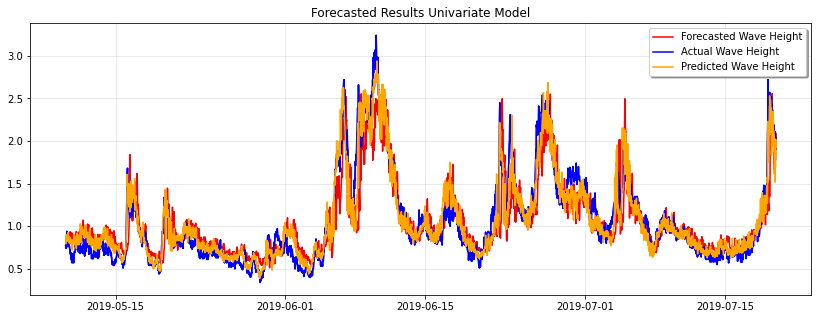

In [ ]:
# VISUALISE PREDICTIONS

rcParams['figure.figsize'] = 14,5

# plot Parameters
START_DATE_FOR_PLOTTING = '2019-05-10 00:00:00'
# FORECASTED DATA (RED)
plt.plot(S2D_Final_df.loc[START_DATE_FOR_PLOTTING:].index, S2D_Final_df.loc[START_DATE_FOR_PLOTTING:]['DynPredCottHeight'], color='r', label= 'Forecasted Wave Height')

# ACTUAL ROTT DATA (BLUE)
plt.plot(S2D_Final_df.loc[START_DATE_FOR_PLOTTING:].index, S2D_Final_df.loc[START_DATE_FOR_PLOTTING:]['CottHeight'], color='b')

# PREVIOUS ROTT HEIGHT DATA (BLUE)
plt.plot(S2D_Final_df.loc[START_DATE_FOR_PLOTTING: ].index, S2D_Final_df.loc[START_DATE_FOR_PLOTTING:]['CottHeight'], color='b', label = "Actual Wave Height")

# PREDICTED ROTT HEIGHT (ORANGE)
plt.plot(S2D_Final_df.loc[START_DATE_FOR_PLOTTING: ].index, S2D_Final_df.loc[START_DATE_FOR_PLOTTING:]['PredCottHeight'], color='orange', label = "Predicted Wave Height")

# VERTICAL LINE (GREEN)
#plt.axvline(x=S2D_Final_df.index[-steps_future:], color='green', linewidth=2,linestyle='--')

# AESTHETICS
plt.grid(which='major', color='#cccccc', alpha=0.5)
plt.legend(shadow=True)
plt.title("Forecasted Results Univariate Model")

# DYNAMIC TO STATIC MODEL 
( ROTTNEST FORECAST(LSTM) TO PREDICT COTTESLOE(GBM Model)

## Setup

In [ ]:
model_to_load = 'RottHeight_Multi_06 Step_HeightWeights.h5'
steps_future= 6


Use forecast model on Rott Height, then use static model on results to get precition for Cott Height


In [ ]:
# LOAD AND DISPLAY
waves = load_wave_data()

waves['DateTime'] = waves.index   # keep DateTime as a separate col for plotting

waves.tail()

,Month,CottHeight,CottPeakPeriod,CottMeanPeriod,CottDirection,CottRadiansRotated,RottHeight,RottMeanPeriod,RottPeakPeriod,RottDirection,RottRadiansRotated,TimeShiftTotal,CottTimeShift,RottTimeShift,RecordGroup,CottDateTimeOrig,RottDateTimeOrig,DateTime
DateTime,,,,,,,,,,,,,,,,,,
2019-07-20 00:30:00,7,2.07,13.333333,5.633803,248.90625,0.504509,3.30,7.272727,14.285714,240.46875,0.357247,10,10,0,25,2019-07-20 00:20:00,2019-07-20 00:30:00,2019-07-20 00:30:00
2019-07-20 01:00:00,7,2.11,10.000000,5.714286,275.62500,0.970839,3.57,7.843137,15.384615,233.43750,0.234529,10,10,0,25,2019-07-20 00:50:00,2019-07-20 01:00:00,2019-07-20 01:00:00
2019-07-20 01:30:00,7,1.98,10.000000,5.555556,260.15625,0.700859,3.24,7.407407,14.285714,229.21875,0.160897,10,10,0,25,2019-07-20 01:20:00,2019-07-20 01:30:00,2019-07-20 01:30:00
2019-07-20 02:00:00,7,2.04,14.285714,5.633803,251.71875,0.553597,4.40,10.000000,28.571429,43.59375,-3.078870,10,10,0,25,2019-07-20 01:50:00,2019-07-20 02:00:00,2019-07-20 02:00:00
2019-07-20 02:30:00,7,2.01,11.764706,5.405405,244.68750,0.430878,3.47,8.333333,16.666667,223.59375,0.062723,10,10,0,25,2019-07-20 02:20:00,2019-07-20 02:30:00,2019-07-20 02:30:00


In [ ]:
n = steps_future
epoch = 100

# REMOVE LAST n OBS. FROM DF. USE THESE TO COMPARE MODEL TO REAL RESULTS
trueset = waves.tail(n)     # n true values to compare with forecast results

# CONSTRUCT DF WITH LAST n OBS. REMOVED. USE df TO FORECAST n VALS
df = waves[:-n+1]           # dataset with 'true values' removed. LSTM will try forecast the next n values. Compare with trueset.

## Multivariate Model

We will keep the keras model structure and hyperparameters identical to the univariate model in order to have a controlled experiment.

### Prepare Data (Multivariate Model)

We will concentrate on a **Multivariate LSTM Model** that predicts **Rottnest Height** given **RottHeight**,	**RottMeanPeriod**,	**RottPeakPeriod**,	**RottRadiansRotated** as the inputs. It is expected that increasing the complexity of the model will reduce the variance and produce a better forecast in comparison to the **null model**.

Below are the steps requried to prepare the data for training.

In [ ]:
# SELECT FEATURES INVOLVED IN TRAINING AND PREDICTIONS
cols = ["RottHeight",	"RottMeanPeriod",	"RottPeakPeriod",	"RottRadiansRotated"]

# ISOLATE TRAINING SET WITH ONLY cols THAT ARE REQUIRED
dataset_train = df[cols]

# CONVERT TO ARRAY
training_set = dataset_train.to_numpy()

# PRINT SUMMARY
print("Training set shape: {}".format(training_set.shape) )
print("Features Selected: {}".format(cols))

Training set shape: (60240, 4)
Features Selected: ['RottHeight', 'RottMeanPeriod', 'RottPeakPeriod', 'RottRadiansRotated']


In [ ]:
# CONSTRUCT X and y SETS
X_mv = []    # each item is a window of size n_past
y_mv = []    # corresponding y val that each window tries to predict

n_future = n    # number of data points to predict in the future
n_past = 96     # number of past data points to use for predicting the future

# BUILD X AND y
for i in range(n_past, len(training_set) - n_future + 1):
  X_mv.append( training_set[ i - n_past:i, 0:dataset_train.shape[1] ] )
  y_mv.append( training_set[ i + n_future - 1:i + n_future, 0 ] )

X_mv, y_mv = np.array(X_mv), np.array(y_mv)

print("X shape: {}".format(X_mv.shape))
print("y shape: {}".format(y_mv.shape))

X shape: (60139, 96, 4)
y shape: (60139, 1)


### Train LSTM Model

In [ ]:
# BUILD LSTM MODEL
model_multivar = Sequential()                                                                               # initialise LSTM neural network

model_multivar.add(LSTM(units=64, return_sequences= True, input_shape=(n_past,dataset_train.shape[1])))     # 1st layer
model_multivar.add(LSTM(units=30, return_sequences = False))                                                # 2nd layer
model_multivar.add(Dropout(0.55))                                                                           # Dropout layer
model_multivar.add(Dense(units=1, activation='linear'))                                                     # Output Layer

model_multivar.compile(optimizer = Adam(learning_rate=0.0001),loss= 'mean_squared_error')                    # compile model

# PRINT SUMMARY
model_multivar.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 96, 64)            17664     
_________________________________________________________________
lstm_9 (LSTM)                (None, 30)                11400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 29,095
Trainable params: 29,095
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# # CALLBACK PARAMS
# es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
# rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
# mcp = ModelCheckpoint(filepath='waveHeightWeights.h5',monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
# tb = TensorBoard('logs')

# # FIT SEQUENTIAL MODEL
# history_multivar = model_multivar.fit(X_mv, y_mv, epochs=epoch, callbacks=[es,rlr,mcp,tb], shuffle=True, validation_split=0.2, verbose=1)

### Loading Weights

In [ ]:
from keras.models import load_model

# returns a compiled model
# identical to the previous one
model=model_multivar.load_weights(model_to_load)

### Evaluation of Model

todo.

In [ ]:
# # PLOT LOSS VALUES
# pyplot.plot(model.history['loss'])
# pyplot.plot(model.history['val_loss'])
# pyplot.title('model train vs validation loss')
# pyplot.ylabel('loss')
# pyplot.xlabel('epoch')
# pyplot.legend(['train', 'validation'], loc='upper right')
# pyplot.show()
# print("mean squared error training: ", history_multivar.history['loss'])
# print("mean squared error validation: ", history_multivar.history['val_loss'])

In [ ]:
# PREDICTIONS MADE ON PAST VALUES
#predictions_past = model_multivar.predict(X_mv[n_past:])

In [ ]:
# PREDICTIONS MADE ON PAST VALUES
predictions_past = model_multivar.predict(X_mv[n_past:])

# CONSTRUCT A DF TO HOLD RESULTS
multivar_pst_result_df = dataset_train[2 * n_past + n_future -1:].copy()                    # now reference the true set
multivar_pst_result_df['PastPredictedRottHeight'] = predictions_past                                 # add prediction column to trueset
multivar_pst_result_df = multivar_pst_result_df.rename(columns={"RottHeight": "ActlRottHeight"})



In [ ]:
# FINAL RESULT
multivar_pst_result_df

,ActlRottHeight,RottMeanPeriod,RottPeakPeriod,RottRadiansRotated,PastPredictedRottHeight
DateTime,,,,,
2015-12-22 01:00:00,0.76,4.705882,15.384615,0.504509,0.938779
2015-12-22 01:30:00,0.72,4.651163,16.666667,0.553597,0.959351
2015-12-22 02:00:00,0.71,4.705882,16.666667,0.529053,0.933412
2015-12-22 02:30:00,0.72,4.597701,15.384615,0.529053,0.979315
2015-12-22 03:00:00,0.73,4.938272,15.384615,0.479966,0.938533
...,...,...,...,...,...
2019-07-19 22:00:00,3.75,7.272727,8.333333,0.406334,4.327269
2019-07-19 22:30:00,3.43,7.017544,13.333333,0.455422,4.165510
2019-07-19 23:00:00,3.44,7.142857,13.333333,0.430878,4.516233


In [ ]:
# PERFORM PREDICTIONS FOR n VALUES
predictions_future = model_multivar.predict(X_mv[-n_future:])

# CONSTRUCT A DF TO HOLD RESULTS
multivar_result_df = trueset.copy()                    # now reference the true set
multivar_result_df['FrcstRottHeight'] = predictions_future   # add prediction column to trueset
#multivar_result_df = multivar_result_df.rename(columns={"RottHeight": "ActlRottHeight"})

# FINAL RESULT
multivar_result_df

,Month,CottHeight,CottPeakPeriod,CottMeanPeriod,CottDirection,CottRadiansRotated,RottHeight,RottMeanPeriod,RottPeakPeriod,RottDirection,RottRadiansRotated,TimeShiftTotal,CottTimeShift,RottTimeShift,RecordGroup,CottDateTimeOrig,RottDateTimeOrig,DateTime,FrcstRottHeight
DateTime,,,,,,,,,,,,,,,,,,,
2019-07-20 00:00:00,7,2.07,11.111111,5.555556,258.75000,0.676315,3.60,7.692308,15.384615,246.09375,0.455422,10,10,0,25,2019-07-19 23:50:00,2019-07-20 00:00:00,2019-07-20 00:00:00,4.273901
2019-07-20 00:30:00,7,2.07,13.333333,5.633803,248.90625,0.504509,3.30,7.272727,14.285714,240.46875,0.357247,10,10,0,25,2019-07-20 00:20:00,2019-07-20 00:30:00,2019-07-20 00:30:00,4.327269
2019-07-20 01:00:00,7,2.11,10.000000,5.714286,275.62500,0.970839,3.57,7.843137,15.384615,233.43750,0.234529,10,10,0,25,2019-07-20 00:50:00,2019-07-20 01:00:00,2019-07-20 01:00:00,4.165510
2019-07-20 01:30:00,7,1.98,10.000000,5.555556,260.15625,0.700859,3.24,7.407407,14.285714,229.21875,0.160897,10,10,0,25,2019-07-20 01:20:00,2019-07-20 01:30:00,2019-07-20 01:30:00,4.516233
2019-07-20 02:00:00,7,2.04,14.285714,5.633803,251.71875,0.553597,4.40,10.000000,28.571429,43.59375,-3.078870,10,10,0,25,2019-07-20 01:50:00,2019-07-20 02:00:00,2019-07-20 02:00:00,4.484653
2019-07-20 02:30:00,7,2.01,11.764706,5.405405,244.68750,0.430878,3.47,8.333333,16.666667,223.59375,0.062723,10,10,0,25,2019-07-20 02:20:00,2019-07-20 02:30:00,2019-07-20 02:30:00,4.423095


## Prediction using Static model

In [ ]:
# Load from file
height_fname = 'height.pkl'
with open(height_fname, 'rb') as file:
    height_model = pickle.load(file)

In [ ]:
height_model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=50,
              objective='regression', random_state=11, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# # WAVE HEIGHT MODEL

# # Load from file
# height_fname = 'height.pkl'
# with open(height_fname, 'rb') as file:
#     height_model = pickle.load(file)

# Feature Engineering      --------------------------------------------------------

# extract the hour, day, and month
height_df = multivar_result_df.copy()
time_series = pd.to_datetime(height_df['DateTime'])
height_df['month'] = time_series.dt.month
height_df['day'] = time_series.dt.day
height_df['hour'] = time_series.dt.hour

del height_df['DateTime']
del height_df['CottPeakPeriod']
del height_df['CottDirection']

order = ['month', 'day', 'hour', 'FrcstRottHeight', 'RottPeakPeriod', 'RottDirection', 'CottHeight']
height_df = height_df[order]

# use bin method to treat time feature as category variable
# After applying to the model, we found that the "bins of hour" almost has no effect on the model result,
# so we remove it to reduce dimension in case of overfitting. 

bins_of_month = [0, 4 ,7, 9, 13]
height_df['month'] = pd.cut(height_df['month'], bins_of_month, labels=[1, 2, 3, 4])

bins_of_day = [0, 10 ,20, 32]
height_df['day'] = pd.cut(height_df['day'], bins_of_day, labels=[1, 2, 3])

# bins_of_hour = [-1, 6 ,12, 18, 25]
# df['hour'] = pd.cut(df['hour'], bins_of_hour, labels=[1, 2, 3,4])
del height_df['hour']
# use OneHot Encoding to make all values of the categorical features are equally away from each other,
# and it help to avoid the overfitting caused by the gradient descent in high dimension. 
col_names = ['month','day']
for col in col_names:  
    OnehotEn = pd.get_dummies(height_df[col], prefix=col)
    height_df.drop([col], axis=1, inplace=True)
    height_df = pd.concat([height_df, OnehotEn], axis=1)


#normalize numerical feature to make the model faster to find the optimal solution during training
z_scaler = lambda x : (x - np.mean(x)) / np.std(x)
height_df_ = height_df[['FrcstRottHeight', 'RottPeakPeriod', 'RottDirection']].apply(z_scaler)

del height_df['FrcstRottHeight']
del height_df['RottPeakPeriod']
del height_df['RottDirection']

height_df = pd.concat([height_df,height_df_],axis=1)
label_y = height_df['CottHeight']
height_df.drop(['CottHeight'], axis=1, inplace=True)

height_df
# # ---------------------------------------------------------------------------------

# Make prediction on dynamic model
height_pred = height_model.predict(height_df)
height_pred.shape
# Update result_df
height_df['PredCottHeight'] =  height_pred
height_df['CottHeight']=label_y
#height_df.tail()





# # # Make prediction on static
# # height_pred = height_model.predict(height_df)
# # height_pred.shape
# # # Update result_df
# # height_df['FrcstCottHeight'] =  height_pred
# # height_df['CottHeight']=label_y
# # #height_df.tail()

In [ ]:
height_df.head()

,month_1,month_2,month_3,month_4,day_1,day_2,day_3,FrcstRottHeight,RottPeakPeriod,RottDirection,PredCottHeight,CottHeight
DateTime,,,,,,,,,,,,
2019-07-20 00:00:00,0,1,0,0,0,1,0,-0.744386,-0.405198,0.606075,0.717745,2.07
2019-07-20 00:30:00,0,1,0,0,0,1,0,-0.308832,-0.622917,0.527449,0.958279,2.07
2019-07-20 01:00:00,0,1,0,0,0,1,0,-1.628986,-0.405198,0.429167,0.393528,2.11
2019-07-20 01:30:00,0,1,0,0,0,1,0,1.233348,-0.622917,0.370197,1.594180,1.98
2019-07-20 02:00:00,0,1,0,0,0,1,0,0.975616,2.207424,-2.224461,1.672439,2.04


#Dynamic to Static Final Result

In [ ]:
# FINAL Dataframe

D2S_Final_df=height_df.drop(height_df.columns.difference(['FrcstRottHeight','PredCottHeight','CottHeight']),axis=1)
D2S_Final_df

,FrcstRottHeight,PredCottHeight,CottHeight
DateTime,,,
2019-07-20 00:00:00,-0.744386,0.717745,2.07
2019-07-20 00:30:00,-0.308832,0.958279,2.07
2019-07-20 01:00:00,-1.628986,0.393528,2.11
2019-07-20 01:30:00,1.233348,1.594180,1.98
2019-07-20 02:00:00,0.975616,1.672439,2.04
2019-07-20 02:30:00,0.473228,1.159019,2.01


## MSE

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

withoutNAN=D2S_Final_df.dropna()
Cott_forecast_MSE=mean_squared_error(withoutNAN['CottHeight'],withoutNAN["PredCottHeight"])

print('Cott Height Forecast: {:2.2}'.format(Cott_forecast_MSE))

Cott Height Forecast: 1.2


## VISUALISE PREDICTIONS

Text(0.5, 1.0, 'Forecasted Results Univariate Model')

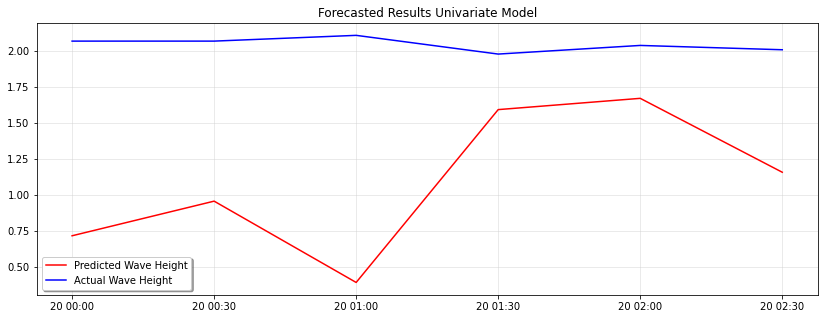

In [ ]:
# VISUALISE PREDICTIONS

rcParams['figure.figsize'] = 14,5

# plot Parameters
START_DATE_FOR_PLOTTING = '2019-05-10 00:00:00'
# FORECASTED DATA (RED)
plt.plot(D2S_Final_df.loc[START_DATE_FOR_PLOTTING:].index, D2S_Final_df.loc[START_DATE_FOR_PLOTTING:]['PredCottHeight'], color='r', label= 'Predicted Wave Height')

# ACTUAL ROTT DATA (BLUE)
#plt.plot(D2S_Final_df.loc[START_DATE_FOR_PLOTTING:].index, D2S_Final_df.loc[START_DATE_FOR_PLOTTING:]['CottHeight'], color='b')

# PREVIOUS COTT HEIGHT DATA (BLUE)
plt.plot(D2S_Final_df.loc[START_DATE_FOR_PLOTTING: ].index, D2S_Final_df.loc[START_DATE_FOR_PLOTTING:]['CottHeight'], color='b', label = "Actual Wave Height")

# PREDICTED ROTT HEIGHT (ORANGE)
#plt.plot(D2S_Final_df.loc[START_DATE_FOR_PLOTTING: ].index, D2S_Final_df.loc[START_DATE_FOR_PLOTTING:]['PredCottHeight'], color='orange', label = "Predicted Wave Height")

# VERTICAL LINE (GREEN)
#plt.axvline(x=D2S_Final_df.index[-steps_future:], color='green', linewidth=2,linestyle='--')

# AESTHETICS
plt.grid(which='major', color='#cccccc', alpha=0.5)
plt.legend(shadow=True)
plt.title("Forecasted Results Univariate Model")

# **PART-3 : CONCLUSION**

After extensive experimentation, the best dynamic model was found to be the prediction plus forecast combination model i.e. Predict Cott Height (LGBM) then forecast Cott(Univariate LSTM). The model has the MSE of 0.058m. This model is also part of the final deployment.